# Bind together all rdb files

These files contain average daily readings from 2/1/1857 to 5/4/2020 

In [ ]:
import pandas as pd
import csv
from zipfile import ZipFile
frames = []
with ZipFile("dv01d.zip") as datazip:
    for filename in datazip.namelist():
        if not filename.endswith(".rdb"):
            continue
        with datazip.open(filename) as f:
            data = pd.read_csv(f, sep="\t", encoding="latin-1", dtype={'site_no': str})
            frames.append(data)
all_data = pd.concat(frames)
 
all_data['result_dt'] = pd.to_datetime(all_data['result_dt'])
 
all_data['year'] = pd.DatetimeIndex(all_data['result_dt']).year #create a field for year
all_data['month'] = pd.DatetimeIndex(all_data['result_dt']).month #create a field for month
all_data['month_year'] = pd.to_datetime(all_data[['year', 'month']].assign(DAY=1)) #create a field for month and year
 
all_data.to_csv("dv01d.csv") 

In [33]:
all_data.head()

,result_dt,result_va,result_cd,parameter_cd,ts_id,dd_nu,site_no,year,month,month_year
0,1935-04-27,264.0,NaN,60,45238.0,1,13041000,1935,4,1935-04-01
1,1935-04-28,277.0,NaN,60,45238.0,1,13041000,1935,4,1935-04-01
2,1935-04-29,295.0,NaN,60,45238.0,1,13041000,1935,4,1935-04-01
3,1935-04-30,328.0,NaN,60,45238.0,1,13041000,1935,4,1935-04-01
4,1935-05-01,324.0,NaN,60,45238.0,1,13041000,1935,5,1935-05-01


# Create a dataframe from the big file that contains only the date of the measurement, the stream flow and the site number 

In [39]:
#all_data.sort_values('result_dt', ascending=True).head()
allsites = all_data[['result_dt', 'site_no', 'year']].copy()
allsites = allsites.drop_duplicates()

# Bind together the water years 2019 and 2020
Water Years are between October 1st of one year and September 30th of the next

Dates in this dataset range from 10/1/2018 to 9/30/2020

In [40]:
df2019 = pd.read_csv('dv_wy2019_A_wus.rdb', sep="\t", encoding="latin-1", dtype={'site_no': str})
df2020 = pd.read_csv('dv_wy2020_A_wus.rdb', sep="\t", encoding="latin-1", dtype={'site_no': str})
df2019['result_dt'] = pd.to_datetime(df2019['result_dt'])
df2020['result_dt'] = pd.to_datetime(df2020['result_dt'])
df = pd.concat([df2019, df2020], ignore_index=True)
df['year'] = pd.DatetimeIndex(df['result_dt']).year #create a field for year
df['month'] = pd.DatetimeIndex(df['result_dt']).month #create a field for month
df['month_year'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1)) #create a field for month and year
df = df[['result_dt', 'site_no', 'year']]
df = df.drop_duplicates()
#df.sort_values('result_dt', ascending=True).head()

In [41]:
df.head()

,result_dt,site_no,year
0,2018-10-01,05014300,2018
1,2018-10-02,05014300,2018
2,2018-10-03,05014300,2018
3,2018-10-04,05014300,2018
4,2018-10-05,05014300,2018


# Concatenate the big file with the 2019 and 2020 file, drop the duplicates

In [42]:
allsites2 = pd.concat([df, allsites], ignore_index=True)
allsites2 = allsites2.drop_duplicates()

# Calculate water year

In [44]:
import numpy as np
#first argument is a condition
#second argument is the value if it is true
#third value is the value if it was false 
allsites2['result_water_year'] = np.where(
    allsites2['result_dt'].dt.month >=10,
    allsites2['result_dt'].dt.year + 1,
    allsites2['result_dt'].dt.year
)

# Find out how many records per year there are

In [88]:
gagecount = allsites2.groupby(['site_no', 'result_water_year'])['site_no'].count().to_frame(name = 'records').reset_index()
gagecount.sort_values('records', ascending=False).head()

,site_no,result_water_year,records
127943,11070270,1972,366
188093,12100496,1992,366
149317,11262900,2004,366
49526,08398500,2020,366
100092,10128500,1988,366


# Select only gages that are 'active' each year
For the purposes of this visualization, "active" streamgages are considered those with at least 335 days of data every year. Early streamgages with only monthly records were counted as active.

In [97]:
active = gagecount[gagecount['records'] > 334]

In [98]:
directory = pd.read_csv('dv01d_por2.rdb', sep="\t", encoding="latin-1", dtype={'site_no': str, 'state_cd': str})
directory['end_dt'] = pd.to_datetime(directory['end_dt'])
directory['begin_dt'] = pd.to_datetime(directory['begin_dt'])

directory['end_water_year'] = np.where(
    directory['end_dt'].dt.month >=10,
    directory['end_dt'].dt.year + 1,
    directory['end_dt'].dt.year
)

directory['begin_water_year'] = np.where(
    directory['begin_dt'].dt.month >=10,
    directory['begin_dt'].dt.year + 1,
    directory['begin_dt'].dt.year
)

In [99]:
directory.dtypes

site_no                     object
station_nm                  object
state_cd                    object
dec_lat_va                 float64
dec_long_va                float64
begin_dt            datetime64[ns]
end_dt              datetime64[ns]
count_nu                     int64
end_water_year               int64
begin_water_year             int64
dtype: object

In [100]:
directory = directory[['site_no', 'state_cd', 'count_nu', 'begin_dt', 'end_dt']]

In [101]:
activegages = active.merge(directory, left_on='site_no', right_on="site_no",how="inner")

In [102]:
utah = activegages[activegages['state_cd'] == '49']
utah2 = utah.groupby(['result_water_year'])['result_water_year'].count().to_frame(name = 'gages').reset_index()

In [103]:
utah2.sort_values('result_water_year', ascending=False).head(60)

,result_water_year,gages
124,2020,133
123,2019,136
122,2018,135
121,2017,135
120,2016,138
119,2015,135
118,2014,133
117,2013,131
116,2012,139
115,2011,137


In [76]:
utah2.to_csv('utah_gages.csv')

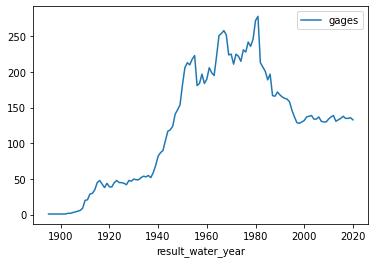

In [105]:
import matplotlib.pyplot as plt
utah2.plot(x='result_water_year', y='gages')
plt.show()